<a href="https://colab.research.google.com/github/ZionOchayon/Machine-Learning-Deep-Learning-Image-Processing/blob/main/LLM_Shapes_Detection%26Coin_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
StudentName = 'Zion Ochayon'
StudentID = '313351942'
StudentMobile = '052-5650698'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Part 1 - Coin detection

## Grab Image from USB Camera

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


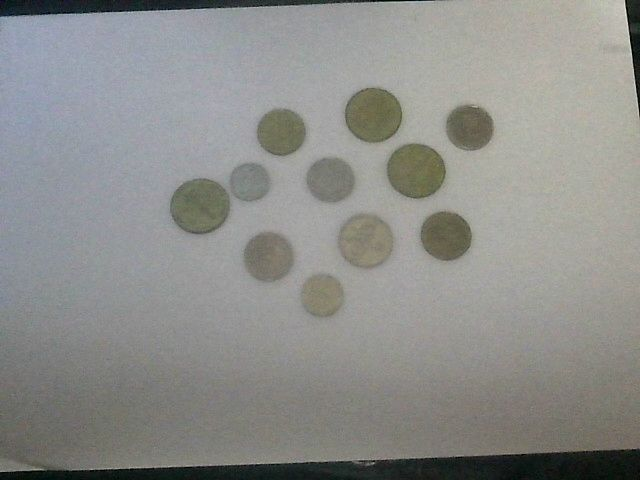

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# Install Required Libraries

!pip install opencv-python-headless numpy

In [ ]:
# Import Libraries: Import the libraries you just installed

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# Load the Image

image = cv2.imread(filename, cv2.IMREAD_COLOR)

In [ ]:
# Preprocess the Image: Convert the image to grayscale and apply Gaussian blur to reduce noise

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 1.5)

In [ ]:
# Detect Circles: Use the Hough Circle Transform to detect circles (coins) in the image

circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=10, maxRadius=60)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)

Number of coins detected: 11


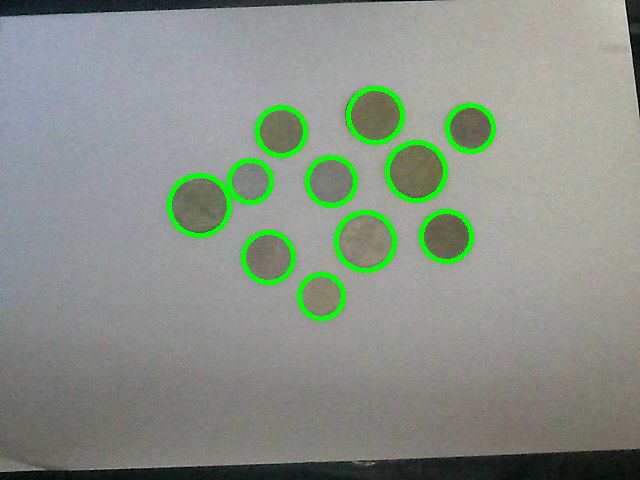

In [ ]:
# Count and Display Coins: Count the number of detected circles and display the result

num_coins = len(circles) if circles is not None else 0
print(f"Number of coins detected: {num_coins}")
cv2_imshow(image)

# Part 2 - Dataset creation and LLM for shapes recognition


In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import random
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import Counte
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def create_image(num_objects):
    # Create a blank 128x128 image with a white background
    img = Image.new('L', (128, 128), 255)
    draw = ImageDraw.Draw(img)

    # Object type and corresponding gray level ranges
    object_types = {
        'circle': (26, 50),
        'triangle': (51, 75),
        'rectangle': (76, 100),
        'ellipse': (101, 125),
        'pentagon': (126, 150),
        'square': (151, 175),
        'hexagon': (176, 200),
        'heart': (201, 225),
        'star': (226, 250)
    }

    # Keep track of occupied areas to avoid overlap
    occupied_areas = []

    # Randomly select and draw objects
    object_labels = []
    for _ in range(num_objects):
        obj_type = random.choice(list(object_types.keys()))
        gray_level = random.randint(*object_types[obj_type])
        obj_size, obj_position = get_object_size_and_position(occupied_areas)
        draw_object(draw, obj_type, gray_level, obj_size, obj_position)
        occupied_areas.append((obj_position, (obj_position[0] + obj_size[0], obj_position[1] + obj_size[1])))
        object_labels.append(obj_type)

    # Draw a random line with a gray level in the range 0-25
    draw_random_line(draw)

    return img, object_labels

def get_object_size_and_position(occupied_areas):
    # Generate a random size and position for the object
    max_attempts = 100
    for _ in range(max_attempts):
        obj_size = (random.randint(10, 40), random.randint(10, 40))
        obj_position = (random.randint(0, 128 - obj_size[0]), random.randint(0, 128 - obj_size[1]))
        if not is_overlapping(obj_position, obj_size, occupied_areas):
            return obj_size, obj_position
    return (10, 10), (0, 0)  # Fallback to a default size and position

def is_overlapping(position, size, occupied_areas):
    # Check if the new object overlaps with any existing object
    x1, y1 = position
    x2, y2 = x1 + size[0], y1 + size[1]
    for area in occupied_areas:
        ax1, ay1 = area[0]
        ax2, ay2 = area[1]
        if not (x2 <= ax1 or x1 >= ax2 or y2 <= ay1 or y1 >= ay2):
            return True
    return False

def draw_object(draw, obj_type, gray_level, size, position):
    # Function to draw different types of objects
    if obj_type == 'circle':
        draw.ellipse([position, (position[0] + size[0], position[1] + size[1])], fill=gray_level)
    elif obj_type == 'triangle':
        draw.polygon([position, (position[0] + size[0], position[1]), (position[0] + size[0] // 2, position[1] + size[1])], fill=gray_level)
    elif obj_type == 'rectangle':
        draw.rectangle([position, (position[0] + size[0], position[1] + size[1])], fill=gray_level)
    elif obj_type == 'ellipse':
        draw.ellipse([position, (position[0] + size[0], position[1] + size[1] // 2)], fill=gray_level)
    elif obj_type == 'square':
        min_side = min(size)
        draw.rectangle([position, (position[0] + min_side, position[1] + min_side)], fill=gray_level)
    elif obj_type == 'pentagon':
        draw.polygon([
            (position[0] + size[0] // 2, position[1]),
            (position[0] + size[0], position[1] + size[1] // 3),
            (position[0] + size[0] * 3 // 4, position[1] + size[1]),
            (position[0] + size[0] // 4, position[1] + size[1]),
            (position[0], position[1] + size[1] // 3)
        ], fill=gray_level)
    elif obj_type == 'hexagon':
        draw.polygon([
            (position[0] + size[0] // 3, position[1]),
            (position[0] + size[0] * 2 // 3, position[1]),
            (position[0] + size[0], position[1] + size[1] // 2),
            (position[0] + size[0] * 2 // 3, position[1] + size[1]),
            (position[0] + size[0] // 3, position[1] + size[1]),
            (position[0], position[1] + size[1] // 2)
        ], fill=gray_level)
    elif obj_type == 'star':
        star_points = []
        for i in range(5):
            star_points.append((position[0] + size[0] // 2 + size[0] // 2 * np.cos(2 * np.pi * i / 5),
                                position[1] + size[1] // 2 + size[1] // 2 * np.sin(2 * np.pi * i / 5)))
            star_points.append((position[0] + size[0] // 2 + size[0] // 4 * np.cos(2 * np.pi * (i + 0.5) / 5),
                                position[1] + size[1] // 2 + size[1] // 4 * np.sin(2 * np.pi * (i + 0.5) / 5)))
        draw.polygon(star_points, fill=gray_level)
    elif obj_type == 'heart':
        draw.polygon([
            (position[0] + size[0] // 2, position[1] + size[1] // 3),
            (position[0] + size[0], position[1] + size[1] // 3),
            (position[0] + size[0] * 3 // 4, position[1] + size[1]),
            (position[0] + size[0] // 4, position[1] + size[1]),
            (position[0], position[1] + size[1] // 3)
        ], fill=gray_level)
        draw.ellipse([position, (position[0] + size[0] // 2, position[1] + size[1] // 2)], fill=gray_level)
        draw.ellipse([(position[0] + size[0] // 2, position[1]), (position[0] + size[0], position[1] + size[1] // 2)], fill=gray_level)


def draw_random_line(draw):
    # Draw a random line with a gray level in the range 0-25
    x1, y1 = random.choice([(0, random.randint(0, 127)), (random.randint(0, 127), 0)])
    x2, y2 = random.choice([(127, random.randint(0, 127)), (random.randint(0, 127), 127)])
    draw.line((x1, y1, x2, y2), fill=random.randint(0, 25), width=1)

def save_images(num_images, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        for i in range(10):
          os.makedirs(os.path.join(output_dir, str(i)))

    for i in range(num_images):
        num_objects = random.randint(0, 9)
        img, object_labels = create_image(num_objects)
        img.save(f'{output_dir}/{random.randint(0, 9)}/image_{i+1}_{num_objects}_{"_".join(object_labels)}.png')

# Generate and save 70,000 images
save_images(70000, '/content/gdrive/MyDrive/image_processing/DataSet')

This code does the following :

 generates images with random objects and lines, and saves them in a directory named dataset. Each image is named according to the number of objects and the types of objects it contains. You can modify the draw_object function to add more shapes or change the way they are drawn.





In [ ]:
def load_dataset(dataset_dir):
    images = []
    labels = []
    for foldername in os.listdir(dataset_dir):
      folderdir = os.path.join(dataset_dir, foldername)
      for filename in os.listdir(folderdir):
          if filename.endswith('.png'):
              img = Image.open(os.path.join(folderdir, filename))
              img = np.array(img) / 255.0  # Normalize to [0, 1]
              images.append(img)
              label = int(filename.split('_')[2])
              labels.append(label)
    return np.array(images), np.array(labels)

# Loads the dataset from the specified directory and normalize values.
X, y = load_dataset('/content/gdrive/MyDrive/image_processing/DataSet')

# Split dataset into training and validation sets
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


# Reshape for CNN input
X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

This code does the following :
1. Loads the dataset from the specified directory and normalize values.
3. Splits the dataset into training and validation sets.
4. Reshapes the images for CNN input.

In [ ]:
# Assuming y is your labels array
class_counts = Counter(y)

print(f"Total : {class_counts.total()}")

# Print the count of each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count}")


Total : 70000
Class 4: 7128
Class 3: 7076
Class 8: 6991
Class 0: 6800
Class 2: 6958
Class 6: 7018
Class 1: 7024
Class 9: 6965
Class 7: 7001
Class 5: 7039


This code does the following :

will print the number of occurrences of each class label in your y array, giving you an overview of the class distribution in your dataset.

In [ ]:
# Model creation
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 classes (0-9 shapes)
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Create and train the model
model = create_model()


# Fit the model on the batches generated by datagen.flow()
history = model.fit(X_train, y_train, batch_size=32,
                    epochs=15,
                    validation_data=(X_val, y_val))

Epoch 1/15
1750/1750 [==============================] - 41s 20ms/step - loss: 1.0786 - accuracy: 0.5437 - val_loss: 0.4523 - val_accuracy: 0.8288
Epoch 2/15
1750/1750 [==============================] - 32s 18ms/step - loss: 0.5635 - accuracy: 0.7755 - val_loss: 0.3075 - val_accuracy: 0.8842
Epoch 3/15
1750/1750 [==============================] - 33s 19ms/step - loss: 0.2975 - accuracy: 0.8916 - val_loss: 0.3104 - val_accuracy: 0.8906
Epoch 4/15
1750/1750 [==============================] - 33s 19ms/step - loss: 0.3551 - accuracy: 0.8780 - val_loss: 0.4090 - val_accuracy: 0.8616
Epoch 5/15
1750/1750 [==============================] - 33s 19ms/step - loss: 0.2517 - accuracy: 0.9115 - val_loss: 0.2831 - val_accuracy: 0.9097
Epoch 6/15
1750/1750 [==============================] - 33s 19ms/step - loss: 0.4534 - accuracy: 0.8220 - val_loss: 0.2472 - val_accuracy: 0.9115
Epoch 7/15
1750/1750 [==============================] - 33s 19ms/step - loss: 0.1756 - accuracy: 0.9364 - val_loss: 0.1769 -

This code does the following:  
5. Creates a simple CNN model.
5. Trains the model on the training set and evaluates it on the validation set.

In [ ]:
# Evaluate model accuracy and print results
train_loss, train_acc = model.evaluate(X_train,  y_train, verbose=2)

print('\nTrain accuracy:', train_acc)

test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2)

print('\nValidation accuracy:', test_acc)

1750/1750 - 10s - loss: 0.0275 - accuracy: 0.9905 - 10s/epoch - 6ms/step

Train accuracy: 0.9905357360839844
438/438 - 2s - loss: 0.0765 - accuracy: 0.9760 - 2s/epoch - 5ms/step

Validation accuracy: 0.9760000109672546


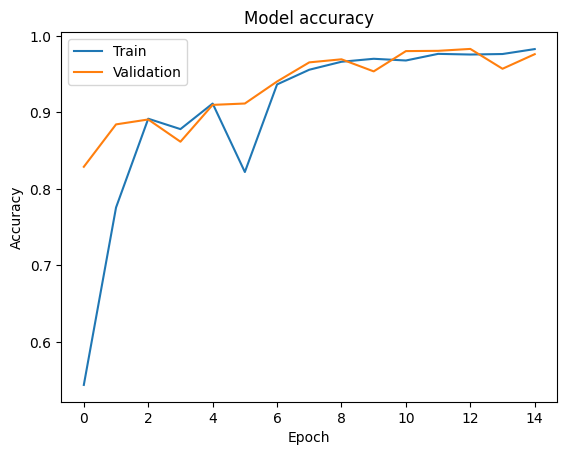

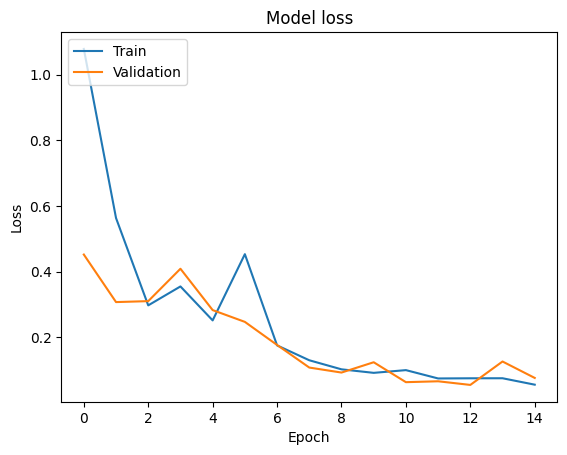

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 21ms/step


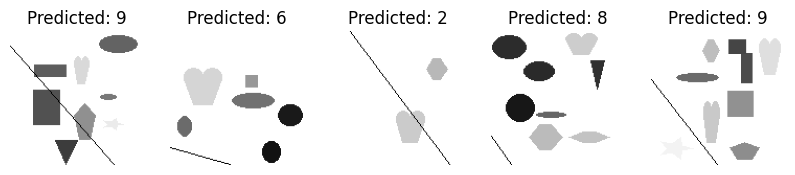

In [ ]:
# Set the number of images to predict
num_images_to_predict = 5

# Generate random indices
random_indices = np.random.choice(X_val.shape[0], size=num_images_to_predict, replace=False)

# Make predictions on the randomly selected images
predictions = model.predict(X_val[random_indices])
predicted_labels = np.argmax(predictions, axis=1)

# Plot the results and the predicted images
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(10, 2))
for i in range(num_images_to_predict):
    axes[i].imshow(X_val[random_indices[i]].reshape(128, 128), cmap='gray')
    axes[i].set_title(f'Predicted: {predicted_labels[i]}')
    axes[i].axis('off')
plt.show()

This code does the following:

Plots and print the accuracy of the model during its training and validation phases.
Defines a plot_predictions function that:
Makes predictions on a given set of images.
Plots each image with its predicted and true labels.
Make sure to run this code after you've trained your model using the previous example. Adjust num_images_to_predict to plot more or fewer images and predictions.





438/438 [==============================] - 2s 5ms/step


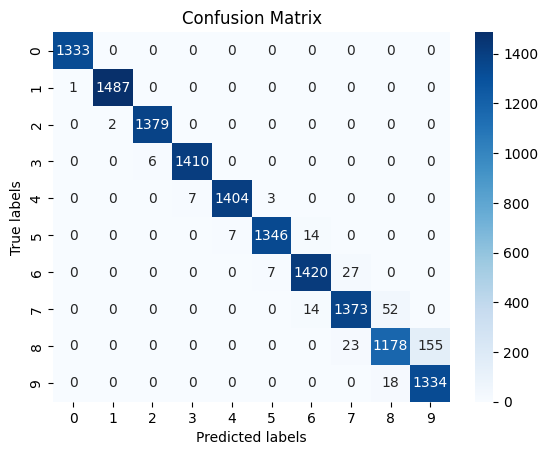

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_val)

# Convert predictions to label indices
y_pred_labels = y_pred.argmax(axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
